In [1]:
# !pip install --quiet --pre dgl-cu101
# !pip install --quiet catboost==0.25.1
# !pip install --quiet category-encoders==2.2.2
# !pip install --quiet torch==1.6.0

In [2]:
import argparse
import itertools
import time
import pickle
import random
from tqdm import tqdm
tqdm.pandas(position=0, leave=True)

from collections import defaultdict as ddict
import pandas as pd
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
import json
import os

from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize

import catboost
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, sum_models
import category_encoders
from category_encoders import CatBoostEncoder

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
import tsne_func

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import dgl
import dgl.nn as dglnn
import dgl.function as Fn

data_dir="/home/ubuntu/"
root_dir="/mnt/bgnn/multi-classification"

os.chdir(root_dir)

print(catboost.__version__)
print(category_encoders.__version__)
print(torch.__version__)

0.25.1
2.2.2
1.6.0


In [3]:
def seed_everything(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [5]:
# KG_dir="/workspace/cjiang/eagle_project/CAP_graph/dataset/"
KG_dir="/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/"
start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph'), 'rb') as f:
    G, node_labels = pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))

It took 7.5383 seconds to load graph


In [5]:
# See CAP_Graph.ipynb for the details of vertices_reindex data creation.
vertices=utils.read_pickle(data_dir,'vertices_reindex')
vertices.head(2)

loading time is 35.4055
The Shape of Dataset is (27884332, 29)


,usaanr,USAAISSUSDT,usaayr,AGE,AGE_BAND,ORIGEL,ELIG2,cmpyelig,SEX,MARST,...,ZIPCD,STATE,Segment,AUT_POL_ANN_PRM_AMT,HO_FIRE_POL_PRM_AMT,REN_POL_PRM_AMT,UMB_POL_PRM_AMT,VPP_POL_PRM_AMT,TOT_PRM_AMT,PROD_TRACE
0,0,1965-01-01,1965,76,71 to 80,0,1) CORE OFFICER,2)USAA,(1)MALE,2)MARRIED,...,28210,32)NO CAROLINA,Bravo,1315.6,1632.0,0.0,366.22,0.0,3313.82,11010
1,1,1990-06-26,1990,67,61 to 70,34)PROBABLE ASSOCIATE MEMBER,6) FAMILY,0,(1)MALE,2)MARRIED,...,98177,46)WASHINGTON,Golf,0.0,0.0,0.0,0.00,0.0,0.00,0


In [6]:
vertices.columns

Index(['usaanr', 'USAAISSUSDT', 'usaayr', 'AGE', 'AGE_BAND', 'ORIGEL', 'ELIG2',
       'cmpyelig', 'SEX', 'MARST', 'PERSST', 'DEATHSDT', 'BRANCH', 'MILST',
       'MLIST_OrigStat', 'enl1stsdt', 'COMMSDT', 'ENLPAYGD', 'ACTCORP',
       'ZIPCD', 'STATE', 'Segment', 'AUT_POL_ANN_PRM_AMT',
       'HO_FIRE_POL_PRM_AMT', 'REN_POL_PRM_AMT', 'UMB_POL_PRM_AMT',
       'VPP_POL_PRM_AMT', 'TOT_PRM_AMT', 'PROD_TRACE'],
      dtype='object')

In [7]:
feat=['usaayr','AGE_BAND','ORIGEL', 'ELIG2', 'cmpyelig','SEX', 'MARST','BRANCH','ENLPAYGD','MILST',
       'MLIST_OrigStat','ACTCORP', 'STATE', 'Segment']
vertices_feat=vertices.loc[:,feat]

for col in vertices_feat:
    vertices_feat[col]=vertices_feat[col].astype('str')
    
categorical_index=np.where(vertices_feat.dtypes==object)[0]
categorical_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

#### regroup label to eliminate rare category

In [8]:
def get_class_count_weight(y,n_classes):
    classes_count=[]
    weight=[]
    for i in range(n_classes):
        count=np.sum(y.squeeze()==i)
        classes_count.append(count)
        weight.append(len(y)/(n_classes*count))
    return classes_count,weight

def predict(X_test, y_test):
    
    preds= model.predict_proba(X_test)

    acc = np.sum(preds.argmax(axis=1) == y_test.squeeze()) / y_test.shape[0]
    prec_macro, recall_macro, fscore_macro, _ = precision_recall_fscore_support(y_test.squeeze(), preds.argmax(axis=1), average='macro')
    prec_micro, recall_micro, fscore_micro, _ = precision_recall_fscore_support(y_test.squeeze(), preds.argmax(axis=1), average='micro')
    prec_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_test.squeeze(), preds.argmax(axis=1), average='weighted')
    
    macro_roc_auc_ovo=roc_auc_score(y_test,preds,multi_class="ovo",average="macro")
    weighted_roc_auc_ovo=roc_auc_score(y_test,preds,multi_class="ovo",average="weighted")

    macro_roc_auc_ovr=roc_auc_score(y_test,preds,multi_class="ovr",average="macro")
    weighted_roc_auc_ovr=roc_auc_score(y_test,preds,multi_class="ovr",average="weighted")
    
    
    _, count=np.unique(y_test,return_counts=True)
    weight=count/count.sum()
    
    y_test_binary=label_binarize(y_test, classes=np.unique(y_test).tolist())
    

    roc_auc = dict()
    pr_auc = dict()
    n_classes = y_test_binary.shape[1]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binary[:, i],preds[:, i])
        roc_auc[i] = auc_score(fpr, tpr)
        
        prec,rec,_ = precision_recall_curve(y_test_binary[:, i], torch.sigmoid(torch.from_numpy(preds))[:,i].numpy())
        pr_auc[i]=auc_score(rec,prec)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_binary.ravel(), preds.ravel())
    roc_auc["micro"] = auc_score(fpr, tpr)
    roc_auc["macro"]=0
    roc_auc["weighted"]=0
    for i in range(n_classes):
        roc_auc["macro"]+=roc_auc[i]
        roc_auc["weighted"]+=roc_auc[i]*weight[i]
    roc_auc["macro"]/=n_classes
    
    prec,rec,_ = precision_recall_curve(y_test_binary.ravel(), torch.sigmoid(torch.from_numpy(preds)).numpy().ravel())
    pr_auc["micro"]=auc_score(rec,prec)

    pr_auc["macro"]=0
    pr_auc["weighted"]=0
    for i in range(n_classes):
        pr_auc["macro"]+=pr_auc[i]
        pr_auc["weighted"]+=pr_auc[i]*weight[i]
    pr_auc["macro"]/=n_classes

    metrics = {}
    metrics['acc'] = acc
    metrics['prec_macro'] = prec_macro
    metrics['recall_macro'] = recall_macro
    metrics['fscore_macro'] = fscore_macro

    metrics['prec_micro'] = prec_micro
    metrics['recall_micro'] = recall_micro
    metrics['fscore_micro'] = fscore_micro

    metrics['prec_weighted'] = prec_weighted
    metrics['recall_weighted'] = recall_weighted
    metrics['fscore_weighted'] = fscore_weighted
    
    metrics['auc_micro']=roc_auc["micro"]
    
    metrics['auc_macro_ovo']=macro_roc_auc_ovo
    metrics['auc_macro_ovr']=macro_roc_auc_ovr
    
    metrics['auc_weighted_ovo']=weighted_roc_auc_ovo
    metrics['auc_weighted_ovr']=weighted_roc_auc_ovr  
    
    metrics['pr_auc_micro']=pr_auc["micro"]
    metrics['pr_auc_macro']=pr_auc["macro"]
    metrics['pr_auc_weighted']=pr_auc["weighted"]

    return metrics, preds, roc_auc, pr_auc


In [9]:
y=node_labels.squeeze().numpy()
n_classes=torch.unique(node_labels).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
imbalance_classes["category"]=torch.unique(node_labels).tolist()
imbalance_classes["product_type"]=["No Product","Rental Only","Home Only","Home + Rental","Auto Only","Auto + Rental","Auto + Home","Auto + Home + Rental"]
imbalance_classes["count"]=classes_count
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","weight":"{:.2f}"})

,category,product_type,count,weight
0,0,No Product,"17,906,619",0.17
1,1,Rental Only,"222,153",13.82
2,2,Home Only,"206,359",14.88
3,3,Home + Rental,"2,522",1217.38
4,4,Auto Only,"2,123,313",1.45
5,5,Auto + Rental,"1,257,366",2.44
6,6,Auto + Home,"2,790,185",1.10
7,7,Auto + Home + Rental,"53,393",57.50


In [10]:
node_labels_new=node_labels.clone()
node_labels_new[node_labels_new==3]=2
node_labels_new[node_labels_new==4]=3
node_labels_new[node_labels_new==5]=4
node_labels_new[node_labels_new==6]=5
node_labels_new[node_labels_new==7]=5

label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

y=node_labels_new.squeeze().numpy()
n_classes=torch.unique(node_labels_new).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
imbalance_classes["category"]=torch.unique(node_labels_new).tolist()
# imbalance_classes["product_type"]=["No Product","Rental Only","Home Only","Auto Only","Auto + Rental","Auto + Home"]
imbalance_classes["product_type"]=[label_map[i] for i in range(n_classes)]
imbalance_classes["count"]=classes_count
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","weight":"{:.2f}"})

,category,product_type,count,weight
0,0,No Product,"17,906,619",0.23
1,1,Rental Only,"222,153",18.43
2,2,Home Only,"208,881",19.60
3,3,Auto Only,"2,123,313",1.93
4,4,Auto + Rental,"1,257,366",3.26
5,5,Auto + Home,"2,843,578",1.44


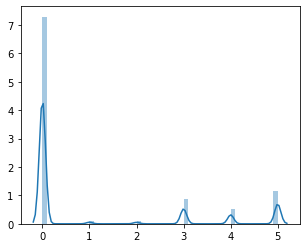

In [11]:
import seaborn as sns
sns.distplot(node_labels_new)

#### Extract Training, Validation and Test Mask

In [12]:
train_mask=G.nodes["usaanr"].data.pop('train_mask')
val_mask=G.nodes["usaanr"].data.pop('val_mask')
test_mask=G.nodes["usaanr"].data.pop('test_mask')

train_idx=torch.nonzero(train_mask.squeeze(1)).numpy()
val_idx=torch.nonzero(val_mask.squeeze(1)).numpy()
test_idx=torch.nonzero(test_mask.squeeze(1)).numpy()

# train_idx=th.from_numpy(train_idx).squeeze(1)    
# val_idx=th.from_numpy(val_idx).squeeze(1)    
# test_idx=th.from_numpy(test_idx).squeeze(1)

label_train=node_labels_new[train_idx].squeeze().numpy()
label_val=node_labels_new[val_idx].squeeze().numpy()
label_test=node_labels_new[test_idx].squeeze().numpy()

df_train=vertices_feat.iloc[train_idx.squeeze(),:]
df_val=vertices_feat.iloc[val_idx.squeeze(),:]
df_test=vertices_feat.iloc[test_idx.squeeze(),:]

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    19,649,532
validation set  2,456,191 
test set        2,456,187 


In [13]:
%%time
params = {'loss_function':'MultiClass',
         'learning_rate' : 0.01,
         'iterations' : 2000,
         'cat_features' : categorical_index,
         'early_stopping_rounds'  : 200,
         'random_seed' : 101,
         'task_type' : "GPU",
         'verbose' : 200}

model=CatBoostClassifier(**params)
model.fit(df_train, label_train, eval_set=(df_val,label_val),use_best_model=True,early_stopping_rounds=50)

0:	learn: 1.7667364	test: 1.7675934	best: 1.7675934 (0)	total: 186ms	remaining: 6m 11s
200:	learn: 0.9214812	test: 0.9215764	best: 0.9215764 (200)	total: 35.1s	remaining: 5m 14s
400:	learn: 0.8929826	test: 0.8930904	best: 0.8930904 (400)	total: 1m 10s	remaining: 4m 39s
600:	learn: 0.8919803	test: 0.8921116	best: 0.8921113 (599)	total: 1m 44s	remaining: 4m 3s
800:	learn: 0.8919453	test: 0.8920826	best: 0.8920815 (787)	total: 2m 18s	remaining: 3m 27s
bestTest = 0.8920808683
bestIteration = 825
Shrink model to first 826 iterations.
CPU times: user 8min 28s, sys: 2min 29s, total: 10min 57s
Wall time: 5min 28s


In [14]:
# def performance_display(df_train,label_train):
    
#     metrics_dict, preds_proba, roc_auc, pr_auc=predict(df_train,label_train)

#     print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
#     print()
#     print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
#           .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
#                   "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
#                  "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

#     print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
#           .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
#                   "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
#                  "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

#     print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
#           .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
#                   "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
#                  "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

#     print()
#     n_classes=torch.unique(node_labels_new).shape[0]
#     label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

#     report=metrics.classification_report(label_train.squeeze(), preds_proba.argmax(axis=1), output_dict=True)

#     table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
#     table["count"]=table["support"].astype(int)
#     table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
#     table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
#     table["product_type"]=[label_map[i] for i in range(n_classes)]
#     table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]
    
#     table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
#                             metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

#     table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
#                                 metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

#     table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
#                             metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

#     table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})

#### performance in training set

In [15]:
print()
print("********  model performance in training set **********")
print()
    
metrics_dict, preds_proba, roc_auc, pr_auc=predict(df_train,label_train)

print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
print()
print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
              "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
             "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
              "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
             "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
              "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
             "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

print()
n_classes=torch.unique(node_labels_new).shape[0]
label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

report=metrics.classification_report(label_train.squeeze(), preds_proba.argmax(axis=1), output_dict=True)

table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
table["count"]=table["support"].astype(int)
table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
table["product_type"]=[label_map[i] for i in range(n_classes)]
table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]

total=table['count'].sum()

table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
                        metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
                            metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
                        metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})


********  model performance in training set **********

accuracy            72.90%    

precision(macro):   12.15%    recall(macro):  16.67%    f1-score(macro):  14.05%    ROC-AUC(macro):  54.46%    PR-AUC(macro):  19.75%    
precision(micro):   72.90%    recall(micro):  72.90%    f1-score(micro):  72.90%    ROC-AUC(micro):  91.25%    PR-AUC(micro):  72.55%    
precision(weight):  53.15%    recall(weight): 72.90%    f1-score(weight): 61.48%    ROC-AUC(weight): 60.20%    PR-AUC(weight): 63.47%    



,product_type,count,precision,recall,f1-score,roc_auc,pr_auc
0,No Product,"14,325,296",72.90%,100.00%,84.33%,64.28%,82.67%
1,Rental Only,"177,723",0.00%,0.00%,0.00%,57.28%,1.10%
2,Home Only,"167,106",0.00%,0.00%,0.00%,58.19%,1.05%
3,Auto Only,"1,698,651",0.00%,0.00%,0.00%,57.51%,10.36%
4,Auto + Rental,"1,005,893",0.00%,0.00%,0.00%,59.13%,6.43%
5,Auto + Home,"2,274,863",0.00%,0.00%,0.00%,66.32%,16.91%
6,MACRO,"19,649,532",12.15%,16.67%,14.05%,54.46%,19.75%
7,MICRO,"19,649,532",72.90%,72.90%,72.90%,91.25%,72.55%
8,WEIGHT,"19,649,532",53.15%,72.90%,61.48%,60.20%,63.47%


#### performance in validation set

In [16]:
print()
print("********  model performance in validation set **********")
print()

metrics_dict, preds_proba, roc_auc, pr_auc=predict(df_val,label_val)

print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
print()
print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
              "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
             "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
              "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
             "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
              "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
             "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

print()
n_classes=torch.unique(node_labels_new).shape[0]
label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

report=metrics.classification_report(label_val.squeeze(), preds_proba.argmax(axis=1), output_dict=True)

table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
table["count"]=table["support"].astype(int)
table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
table["product_type"]=[label_map[i] for i in range(n_classes)]
table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]

total=table['count'].sum()

table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
                            metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
                            metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
                            metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})


********  model performance in validation set **********

accuracy            72.90%    

precision(macro):   12.15%    recall(macro):  16.67%    f1-score(macro):  14.05%    ROC-AUC(macro):  54.23%    PR-AUC(macro):  19.69%    
precision(micro):   72.90%    recall(micro):  72.90%    f1-score(micro):  72.90%    ROC-AUC(micro):  91.24%    PR-AUC(micro):  72.48%    
precision(weight):  53.15%    recall(weight): 72.90%    f1-score(weight): 61.48%    ROC-AUC(weight): 60.00%    PR-AUC(weight): 63.39%    



,product_type,count,precision,recall,f1-score,roc_auc,pr_auc
0,No Product,"1,790,662",72.90%,100.00%,84.33%,64.16%,82.59%
1,Rental Only,"22,215",0.00%,0.00%,0.00%,56.86%,1.08%
2,Home Only,"20,888",0.00%,0.00%,0.00%,57.85%,1.03%
3,Auto Only,"212,331",0.00%,0.00%,0.00%,57.22%,10.26%
4,Auto + Rental,"125,737",0.00%,0.00%,0.00%,58.93%,6.34%
5,Auto + Home,"284,358",0.00%,0.00%,0.00%,66.26%,16.82%
6,MACRO,"2,456,191",12.15%,16.67%,14.05%,54.23%,19.69%
7,MICRO,"2,456,191",72.90%,72.90%,72.90%,91.24%,72.48%
8,WEIGHT,"2,456,191",53.15%,72.90%,61.48%,60.00%,63.39%


#### performance in test set

In [17]:
print()
print("********  model performance in test set **********")
print()

metrics_dict, preds_proba, roc_auc, pr_auc=predict(df_test,label_test)

print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
print()
print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
              "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
             "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
              "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
             "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
              "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
             "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

print()
n_classes=torch.unique(node_labels_new).shape[0]
label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

report=metrics.classification_report(label_test.squeeze(), preds_proba.argmax(axis=1), output_dict=True)

table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
table["count"]=table["support"].astype(int)
table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
table["product_type"]=[label_map[i] for i in range(n_classes)]
table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]

total=table['count'].sum()

table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
                            metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
                            metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
                            metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})


********  model performance in test set **********

accuracy            72.90%    

precision(macro):   12.15%    recall(macro):  16.67%    f1-score(macro):  14.05%    ROC-AUC(macro):  54.24%    PR-AUC(macro):  19.68%    
precision(micro):   72.90%    recall(micro):  72.90%    f1-score(micro):  72.90%    ROC-AUC(micro):  91.23%    PR-AUC(micro):  72.49%    
precision(weight):  53.15%    recall(weight): 72.90%    f1-score(weight): 61.48%    ROC-AUC(weight): 60.00%    PR-AUC(weight): 63.39%    



,product_type,count,precision,recall,f1-score,roc_auc,pr_auc
0,No Product,"1,790,661",72.90%,100.00%,84.33%,64.16%,82.60%
1,Rental Only,"22,215",0.00%,0.00%,0.00%,57.05%,1.08%
2,Home Only,"20,887",0.00%,0.00%,0.00%,57.77%,1.03%
3,Auto Only,"212,331",0.00%,0.00%,0.00%,57.33%,10.26%
4,Auto + Rental,"125,736",0.00%,0.00%,0.00%,58.81%,6.33%
5,Auto + Home,"284,357",0.00%,0.00%,0.00%,66.20%,16.77%
6,MACRO,"2,456,187",12.15%,16.67%,14.05%,54.24%,19.68%
7,MICRO,"2,456,187",72.90%,72.90%,72.90%,91.23%,72.49%
8,WEIGHT,"2,456,187",53.15%,72.90%,61.48%,60.00%,63.39%


In [18]:
# from sklearn import svm, datasets
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp
# from sklearn.metrics import roc_auc_score

# label_test_binary=label_binarize(label_test, classes=np.unique(label_test).tolist())

# preds_proba_test=model.predict_proba(df_test)

# print(label_test_binary.shape)
# print(preds_proba_test.shape)

# preds_proba_test

In [19]:
model.evals_result_.keys()

dict_keys(['learn', 'validation'])

In [20]:
# params = {'loss_function':'MultiClass',
#          'learning_rate' : 0.01,
#          'iterations' : 1000,
#          'cat_features' : categorical_index,
#          'early_stopping_rounds'  : 100,
#          'random_seed' : 101,
#          'task_type' : "GPU",
#          'verbose' : 100}

In [21]:
class GBDTCatBoost:
    def __init__(self,task="classification",depth=6,lr=0.1,l2_leaf_reg=None,max_bin=None,class_weights=None):
        self.task=task
        self.depth=depth
        self.learning_rate=lr
        self.l2_leaf_reg=l2_leaf_reg
        self.max_bin=max_bin
        self.class_weights=class_weights
        
    def init_model(self,num_epochs,patience):
        catboost_model_obj=CatBoostClassifier if self.task== else CatBoostRegressor
        self.catboost_loss_function = 'MultiClass' if self.task == "classification" else 'RMSE' 
        self.custom_metrics = ['Accuracy'] if self.task == "classification" else ["R2"]
        
        self.model = catboost_model_obj(iterations=num_epochs,
                                       depth=self.depth,
                                       learning_rate=self.learning_rate,
                                       loss_function=self.catboost_loss_function,
                                       custom_metric=self.custom_metrics,
                                       random_seed=101,
                                       early_stopping_rounds=patience,
                                       l2_leaf_reg=self.l2_leaf_reg,
                                       max_bin=self.max_bin,
                                       nan_mode='Min',
                                       class_weights=self.class_weights,
                                       task_type="GPU",
                                       verbose=False)
        
    def get_metrics(self):
        d = self.model.evals_result_
        metrics = ddict(list)
        keys = ['learn', 'validation_0', 'validation_1'] \
            if 'validation_0' in self.model.evals_result_ \
            else ['learn', 'validation']
        for metric_name in d[keys[0]]:
            perf = [d[key][metric_name] for key in keys]
            if metric_name == self.catboost_loss_function:
                metrics['loss'] = list(zip(*perf))
            else:
                metrics[metric_name.lower()] = list(zip(*perf))

        return metrics
    
    def get_test_metric(self, metrics, metric_name):
        if metric_name == 'loss':
            val_epoch = np.argmin([acc[1] for acc in metrics[metric_name]])
        else:
            val_epoch = np.argmax([acc[1] for acc in metrics[metric_name]])
        min_metric = metrics[metric_name][val_epoch]
        return min_metric, val_epoch
    
    def save_metrics(self, metrics, fn):
        with open(fn, "w+") as f:
            for key, value in metrics.items():
                print(key, value, file=f)

    def train_val_test_split(self, X, y, train_mask, val_mask, test_mask):
        X_train, y_train = X.iloc[train_mask], y.iloc[train_mask]
        X_val, y_val = X.iloc[val_mask], y.iloc[val_mask]
        X_test, y_test = X.iloc[test_mask], y.iloc[test_mask]
        return X_train, y_train, X_val, y_val, X_test, y_test
    

    def fit(self,
            X, y, train_mask, val_mask, test_mask,
            cat_features=None, num_epochs=1000, patience=200,
            plot=False, verbose=False,
            loss_fn="", metric_name='loss'):

        X_train, y_train, X_val, y_val, X_test, y_test = \
            self.train_val_test_split(X, y, train_mask, val_mask, test_mask)
        self.init_model(num_epochs, patience)

        start = time.time()
        pool = Pool(X_train, y_train, cat_features=cat_features)
        eval_set = [(X_val, y_val), (X_test, y_test)]
        self.model.fit(pool, eval_set=eval_set, plot=plot, verbose=verbose)
        finish = time.time()

        num_trees = self.model.tree_count_
        print('Finished training. Total time: {:.2f} | Number of trees: {:d} | Time per tree: {:.2f}'.format(finish - start, num_trees, (time.time() - start )/num_trees))

        metrics = self.get_metrics()
        min_metric, min_val_epoch = self.get_test_metric(metrics, metric_name)
        if loss_fn:
            self.save_metrics(metrics, loss_fn)
        print('Best {} at iteration {}: {:.3f}/{:.3f}/{:.3f}'.format(metric_name, min_val_epoch, *min_metric))
        return metrics
    
    def predict(self, X_test, y_test):
        preds= self.model.predict_proba(X_test)
        
        acc = np.sum(preds.argmax(axis=1) == y_test.squeeze()) / y_test.shape[0]
        prec_macro, recall_macro, fscore_macro, _ = precision_recall_fscore_support(y_test.squeeze(), preds.argmax(axis=1), average='macro')
        prec_micro, recall_micro, fscore_micro, _ = precision_recall_fscore_support(y_test.squeeze(), preds.argmax(axis=1), average='micro')
        prec_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_test.squeeze(), preds.argmax(axis=1), average='weighted')

        metrics = {}
        metrics['acc'] = acc
        metrics['prec_macro'] = prec_macro
        metrics['recall_macro'] = recall_macro
        metrics['fscore_macro'] = fscore_macro

        metrics['prec_micro'] = prec_micro
        metrics['recall_micro'] = recall_micro
        metrics['fscore_micro'] = fscore_micro
        
        metrics['prec_weighted'] = prec_weighted
        metrics['recall_weighted'] = recall_weighted
        metrics['fscore_weighted'] = fscore_weighted
        
        return metrics

SyntaxError: invalid syntax (<ipython-input-21-0b7107b9bde4>, line 11)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from itertools import cycle

# from sklearn import svm, datasets
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp
# from sklearn.metrics import roc_auc_score

# # Import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target

# y1=np.random.permutation(y)

# label_binarize(y1, classes=[0, 1, 2])